In [307]:
import pandas as pd
import nltk
from bertopic import BERTopic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import itertools
from wordcloud import WordCloud, STOPWORDS

from src.features.preprocess_old import PreProcess

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

from gensim import corpora, models
import gensim

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saimuktevi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saimuktevi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Iteration 1 - Understanding the Data

In [261]:
def remove_escape_chars(s):
    """
    Helper function used to replace hashtags with empty string
    """
    if isinstance(s, str):
        return re.sub(r'\n', '', s)
    else:
        return s
def filter_urls(s):
    """
    Helper function used to replace URLs with empty string
    """
    if isinstance(s, str):
        return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', s, flags=re.MULTILINE)
    else:
        return s

In [262]:
subreddit = "computerscience"

## EDA Posts

In [263]:
world_posts = pd.read_csv('../data/raw/{}_posts.csv'.format(subreddit))
world_comments = pd.read_csv('../data/raw/{}_comments.csv'.format(subreddit))

In [264]:
world_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created
0,n2n0ax,New to programming or computer science? Want a...,375,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1037,The previous thread was finally archived with ...,1.619890e+09
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,404,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09
2,s8afrp,Ways to learn higher level math through CS?,12,0.88,computerscience,https://www.reddit.com/r/computerscience/comme...,3,"I'm a university student, and while I've taken...",1.642654e+09
3,s7yrsa,Why is there nothing between 8bit and 16bit?,23,0.82,computerscience,https://www.reddit.com/r/computerscience/comme...,19,"For example, if i want to change the image spe...",1.642622e+09
4,s7li8v,Why is Internet/transmission speed in Bit and ...,59,0.95,computerscience,https://www.reddit.com/r/computerscience/comme...,41,I am always wondering about this. Why Internet...,1.642581e+09


In [265]:
preprocessed_df = PreProcess.preprocess(world_posts, 'body')
for i in range(len(preprocessed_df.index)):
    preprocessed_df.at[i, 'body_string'] = ' '.join([str(elem) for elem in preprocessed_df.at[i, 'body_stem']])
preprocessed_df['body'] = preprocessed_df['body'].apply(remove_escape_chars)
preprocessed_df['body'] = preprocessed_df['body'].apply(filter_urls)

In [266]:
preprocessed_df.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,body_word_token,body_filtered,body_stem,body_string
0,n2n0ax,New to programming or computer science? Want a...,375,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1037,The previous thread was finally archived with ...,1.619890e+09,"[The, previous, thread, was, finally, archived...","[previous, thread, finally, archived, 500, com...","[previou, thread, final, archiv, 500, comment,...",previou thread final archiv 500 comment repli
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,404,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupportComputer Recommend...,1.634619e+09,"[Tech, Support, :, /r/techsupport, Computer, R...","[tech, support, rtechsupport, computer, recomm...","[tech, support, rtechsupport, comput, recommen...",tech support rtechsupport comput recommend rsu...
2,s8afrp,Ways to learn higher level math through CS?,12,0.88,computerscience,https://www.reddit.com/r/computerscience/comme...,3,"I'm a university student, and while I've taken...",1.642654e+09,"[I, 'm, a, university, student, ,, and, while,...","[university, student, taken, math, classes, la...","[univers, student, taken, math, class, la, mul...",univers student taken math class la multivari ...
3,s7yrsa,Why is there nothing between 8bit and 16bit?,23,0.82,computerscience,https://www.reddit.com/r/computerscience/comme...,19,"For example, if i want to change the image spe...",1.642622e+09,"[For, example, ,, if, i, want, to, change, the...","[example, want, change, image, specifications,...","[exampl, want, chang, imag, specif, photoshop,...",exampl want chang imag specif photoshop choos ...
4,s7li8v,Why is Internet/transmission speed in Bit and ...,59,0.95,computerscience,https://www.reddit.com/r/computerscience/comme...,41,I am always wondering about this. Why Internet...,1.642581e+09,"[I, am, always, wondering, about, this, .]","[always, wondering]","[alway, wonder]",alway wonder


In [267]:
def eda(df, pre='body'):
    print("Number of Posts:",df.shape[0])
    
    all_words = [word for tokens in df[pre + '_filtered'] for word in tokens]
    post_lengths = [len(tokens) for tokens in df[pre + '_filtered']]
    vocab = sorted(list(set(all_words)))

    print('{} words total (after preprocessing), with a vocabulary size of {}'.format(len(all_words), len(vocab)))
    print('Max post length is {}'.format(max(post_lengths)))
    
    flat_words = [item for sublist in df[pre + '_filtered'] for item in sublist]
    word_freq = FreqDist(flat_words)
    fdf = pd.DataFrame(word_freq.most_common(20), columns=['word', 'frequency'])
    fdf.plot(kind='bar', x='word', rot=70)

Number of Posts: 492
4425 words total (after preprocessing), with a vocabulary size of 1944
Max post length is 72


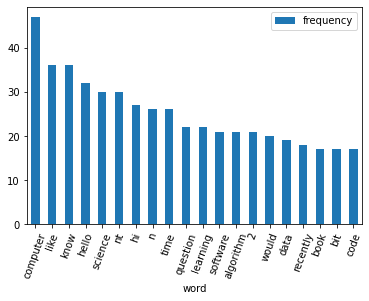

In [268]:
eda(preprocessed_df)

## EDA Comments 

In [269]:
world_comments.head()

,post_id,comment
0,n2n0ax,How late is too late to start a career in prog...
1,n2n0ax,I am a freshman at a university and haven't be...
2,n2n0ax,I'm still in highschool but really interested ...
3,n2n0ax,"This is probably a common question, but how we..."
4,n2n0ax,I am planning on starting a CS major this fall...


In [270]:
preprocessed_df_comments = PreProcess.preprocess(world_comments, 'comment')
for i in range(len(preprocessed_df_comments.index)):
    preprocessed_df_comments.at[i, 'comment_string'] = ' '.join([str(elem) for elem in preprocessed_df_comments.at[i, 'comment_stem']])
preprocessed_df_comments.head()    

,post_id,comment,comment_word_token,comment_filtered,comment_stem,comment_string
0,n2n0ax,How late is too late to start a career in prog...,"[How, late, is, too, late, to, start, a, caree...","[late, late, start, career, programming]","[late, late, start, career, program]",late late start career program
1,n2n0ax,I am a freshman at a university and haven't be...,"[I, am, a, freshman, at, a, university, and, h...","[freshman, university, nt, able, work, side, p...","[freshman, univers, nt, abl, work, side, proje...",freshman univers nt abl work side project lear...
2,n2n0ax,I'm still in highschool but really interested ...,"[I, 'm, still, in, highschool, but, really, in...","[still, highschool, really, interested, comput...","[still, highschool, realli, interest, comput, ...",still highschool realli interest comput scienc
3,n2n0ax,"This is probably a common question, but how we...","[This, is, probably, a, common, question, ,, b...","[probably, common, question, well, coding, boo...","[probabl, common, question, well, code, bootca...",probabl common question well code bootcamp wor...
4,n2n0ax,I am planning on starting a CS major this fall...,"[I, am, planning, on, starting, a, CS, major, ...","[planning, starting, cs, major, fall]","[plan, start, cs, major, fall]",plan start cs major fall


In [271]:
# print("For post_id = n2n0ax:")
# eda(preprocessed_df_comments[preprocessed_df_comments.post_id == 'n2n0ax'], "comment")

In [272]:
# display(preprocessed_df[preprocessed_df.post_id == 'n2n0ax'])
# print("\n>>>>Title: \n", preprocessed_df[preprocessed_df.post_id == 'n2n0ax'].title[0])
# print("\n>>>>Body: \n",preprocessed_df[preprocessed_df.post_id == 'n2n0ax'].body[0])

## BERTopic on Posts Text (Body)

In [273]:
preprocessed_df.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,body_word_token,body_filtered,body_stem,body_string
0,n2n0ax,New to programming or computer science? Want a...,375,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1037,The previous thread was finally archived with ...,1.619890e+09,"[The, previous, thread, was, finally, archived...","[previous, thread, finally, archived, 500, com...","[previou, thread, final, archiv, 500, comment,...",previou thread final archiv 500 comment repli
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,404,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupportComputer Recommend...,1.634619e+09,"[Tech, Support, :, /r/techsupport, Computer, R...","[tech, support, rtechsupport, computer, recomm...","[tech, support, rtechsupport, comput, recommen...",tech support rtechsupport comput recommend rsu...
2,s8afrp,Ways to learn higher level math through CS?,12,0.88,computerscience,https://www.reddit.com/r/computerscience/comme...,3,"I'm a university student, and while I've taken...",1.642654e+09,"[I, 'm, a, university, student, ,, and, while,...","[university, student, taken, math, classes, la...","[univers, student, taken, math, class, la, mul...",univers student taken math class la multivari ...
3,s7yrsa,Why is there nothing between 8bit and 16bit?,23,0.82,computerscience,https://www.reddit.com/r/computerscience/comme...,19,"For example, if i want to change the image spe...",1.642622e+09,"[For, example, ,, if, i, want, to, change, the...","[example, want, change, image, specifications,...","[exampl, want, chang, imag, specif, photoshop,...",exampl want chang imag specif photoshop choos ...
4,s7li8v,Why is Internet/transmission speed in Bit and ...,59,0.95,computerscience,https://www.reddit.com/r/computerscience/comme...,41,I am always wondering about this. Why Internet...,1.642581e+09,"[I, am, always, wondering, about, this, .]","[always, wondering]","[alway, wonder]",alway wonder


In [274]:
docs = list(preprocessed_df['body'])
docs[:3]

['The previous thread was finally archived with over 500 comments and replies! As well, it helped to *massively* cut down on the number of off topic posts on this subreddit, so that was awesome!This is the only place where college, career, and programming questions are allowed. They will be removed if they\'re posted anywhere else.HOMEWORK HELP, TECH SUPPORT, AND PC PURCHASE ADVICE ARE STILL NOT ALLOWED!There are numerous subreddits more suited to those posts such as:/r/techsupport  /r/learnprogramming  /r/buildapc  /r/cscareerquestions  /r/csMajors Note: this thread is in "contest mode" so all questions have a chance at being at the top',
 "Tech Support: /r/techsupportComputer Recommendations: /r/SuggestALaptop or /r/buildapcSorry if this comes off as rude, but despite the previous stickied post people keep making posts asking for tech support or asking which Mac Book they should buy for college. This isn't the subreddit for those posts. Computer Science != IT ~~despite what all my re

In [275]:
docs

['The previous thread was finally archived with over 500 comments and replies! As well, it helped to *massively* cut down on the number of off topic posts on this subreddit, so that was awesome!This is the only place where college, career, and programming questions are allowed. They will be removed if they\'re posted anywhere else.HOMEWORK HELP, TECH SUPPORT, AND PC PURCHASE ADVICE ARE STILL NOT ALLOWED!There are numerous subreddits more suited to those posts such as:/r/techsupport  /r/learnprogramming  /r/buildapc  /r/cscareerquestions  /r/csMajors Note: this thread is in "contest mode" so all questions have a chance at being at the top',
 "Tech Support: /r/techsupportComputer Recommendations: /r/SuggestALaptop or /r/buildapcSorry if this comes off as rude, but despite the previous stickied post people keep making posts asking for tech support or asking which Mac Book they should buy for college. This isn't the subreddit for those posts. Computer Science != IT ~~despite what all my re

In [276]:
#Run BERTopic
topic_model = BERTopic(language="english", embedding_model="paraphrase-multilingual-mpnet-base-v2", min_topic_size=3, calculate_probabilities=True, verbose=True)
# topic_model = BERTopic(language="english", min_topic_size=3, calculate_probabilities=True, verbose=True)
# topic_model = BERTopic(language="english", embedding_model="all-mpnet-base-v2", min_topic_size=3, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

2022-02-01 12:23:11,380 - BERTopic - Transformed documents to Embeddings


2022-02-01 12:23:13,796 - BERTopic - Reduced dimensionality with UMAP
2022-02-01 12:23:13,844 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [277]:
docs[:3]

['The previous thread was finally archived with over 500 comments and replies! As well, it helped to *massively* cut down on the number of off topic posts on this subreddit, so that was awesome!This is the only place where college, career, and programming questions are allowed. They will be removed if they\'re posted anywhere else.HOMEWORK HELP, TECH SUPPORT, AND PC PURCHASE ADVICE ARE STILL NOT ALLOWED!There are numerous subreddits more suited to those posts such as:/r/techsupport  /r/learnprogramming  /r/buildapc  /r/cscareerquestions  /r/csMajors Note: this thread is in "contest mode" so all questions have a chance at being at the top',
 "Tech Support: /r/techsupportComputer Recommendations: /r/SuggestALaptop or /r/buildapcSorry if this comes off as rude, but despite the previous stickied post people keep making posts asking for tech support or asking which Mac Book they should buy for college. This isn't the subreddit for those posts. Computer Science != IT ~~despite what all my re

In [278]:
#Get freq distb of topics
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name
0,-1,112,-1_and_to_the_it
1,0,80,0____
2,1,48,1_the_is_of_if
3,2,28,2_memory_the_is_in
4,3,18,3_turing_the_test_tm
5,4,17,4_key_password_hash_it
6,5,17,5_to_math_book_you
7,6,16,6_coding_to_learn_you
8,7,15,7_are_computer_science_posts
9,8,14,8_ip_server_ms_packet


In [279]:
topic_nr = freq.iloc[2]["Topic"]
topic_model.get_topic(topic_nr)

[('the', 0.02800521712701248),
 ('is', 0.02485250928985895),
 ('of', 0.023200779292127337),
 ('if', 0.02274212790603),
 ('to', 0.021487791032515552),
 ('bill', 0.020204259347583187),
 ('case', 0.01856241900465138),
 ('that', 0.018054613305503495),
 ('ernie', 0.017810673372110022),
 ('tony', 0.017810673372110022)]

In [280]:
topic_model.visualize_topics()

# Iteration 2

## 1. Topic Modelling for Posts using BERTopic

In [281]:
def train_bert(df, column):
    topic_model = BERTopic(language="english", embedding_model="paraphrase-multilingual-mpnet-base-v2", min_topic_size=3, calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(df[column])
    freq = topic_model.get_topic_info()
    docs = topic_model.get_representative_docs()
    topic_names = []
    for i in topics:
        topic_names.append(list(freq[freq['Topic'] == i]["Name"])[0])
    df['topic_label'] = topics
    df['topic_name'] = topic_names
    return topics, probs, topic_model, freq, df

In [282]:
# topic, probs, topic_model, freq, topic_df = train_bert(preprocessed_df, 'body')

2022-02-01 12:26:44,704 - BERTopic - Transformed documents to Embeddings


2022-02-01 12:26:47,163 - BERTopic - Reduced dimensionality with UMAP
2022-02-01 12:26:47,196 - BERTopic - Clustered UMAP embeddings with HDBSCAN


2022-02-01 12:27:49,923 - BERTopic - Transformed documents to Embeddings


2022-02-01 12:27:51,991 - BERTopic - Reduced dimensionality with UMAP
2022-02-01 12:27:52,051 - BERTopic - Clustered UMAP embeddings with HDBSCAN


## 2. Sentiment Analysis for Posts using BERT

In [284]:
# !pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 2.6 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 717.2 kB/s eta 0:00:0000:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.8 MB/s eta 0:00:0000:0100:01


In [285]:
# !pip install transformers requests beautifulsoup4

In [286]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [287]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [288]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [290]:
preprocessed_df['sentiment'] = preprocessed_df['body'].apply(lambda x: sentiment_score(x[:512]))

In [291]:
preprocessed_df[['body','sentiment']]

,body,sentiment
0,The previous thread was finally archived with ...,5
1,Tech Support: /r/techsupportComputer Recommend...,1
2,"I'm a university student, and while I've taken...",2
3,"For example, if i want to change the image spe...",3
4,I am always wondering about this. Why Internet...,2
...,...,...
487,,4
488,I hear lots of people think that Computer Scie...,2
489,,4
490,,4


In [292]:
preprocessed_df['body'][0]

'The previous thread was finally archived with over 500 comments and replies! As well, it helped to *massively* cut down on the number of off topic posts on this subreddit, so that was awesome!This is the only place where college, career, and programming questions are allowed. They will be removed if they\'re posted anywhere else.HOMEWORK HELP, TECH SUPPORT, AND PC PURCHASE ADVICE ARE STILL NOT ALLOWED!There are numerous subreddits more suited to those posts such as:/r/techsupport  /r/learnprogramming  /r/buildapc  /r/cscareerquestions  /r/csMajors Note: this thread is in "contest mode" so all questions have a chance at being at the top'

In [293]:
preprocessed_df['body'][1]

"Tech Support: /r/techsupportComputer Recommendations: /r/SuggestALaptop or /r/buildapcSorry if this comes off as rude, but despite the previous stickied post people keep making posts asking for tech support or asking which Mac Book they should buy for college. This isn't the subreddit for those posts. Computer Science != IT ~~despite what all my relatives think~~. This thread also is not the place for those questions. Use one of the above subreddits."

## 3. Sentiment Analysis for Associated Comments using BERT